In [1]:
import pandas as pd
import os
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def load_data(folder_path, system_list, header):
    dataframes = []
    for csv_file in filter(lambda x:x.endswith(".csv"), os.listdir(folder_path)):
        #print(csv_file)
        #df = pd.read_csv(csv_file, names= ["Dataset", "Top K", "QTS", "ndcg@10","ndcg@1000","recall@1000","Score QTS", "GPU to CPU"])
        
        df = pd.read_csv(os.path.join(folder_path, csv_file), names= header)
        df.insert(0, "System", csv_file[:-4], True)
        #print(len(df.columns))
        #if len(df.columns) == 3:
        #    df.names = ["Dataset", "Top K", "QTS"]
        #else:
        #    df.names = ["Dataset", "Top K", "QTS", "Score QTS", "Mem transference"]
        dataframes.append(df)

    data = pd.concat(dataframes, axis=0, ignore_index=True)
    systems_to_keep = system_list

    return  data[data['System'].isin(systems_to_keep)]



    

In [8]:
data_se = load_data("../results",['pyserini', 'pyterrier'], header=["Dataset", "Top K", "QTS", "ndcg@10","ndcg@1000","recall@1000","Score QTS", "GPU to CPU"])
data_se = data_se[data_se["Dataset"]=="beir_datasets/msmarco"][["System", "Top K", "QTS"]]



,System,Top K,QTS
155,pyterrier,10,32.048451
156,pyterrier,100,25.755687
157,pyterrier,1000,10.238099
158,pyterrier,10000,1.189518
185,pyserini,10,109.460328
186,pyserini,100,62.265838
187,pyserini,1000,26.544633
188,pyserini,10000,5.738643


In [107]:
def compute_speedup_against(framework):
    _header = ["Dataset", "Top K", "QTS", "ndcg@10","ndcg@1000","recall@1000","Score QTS", "GPU to CPU"]
    data_se = load_data("../results",['pyserini', 'pyterrier'], header=_header)
    data_se = data_se[data_se["Dataset"]=="beir_datasets/msmarco"][["System", "Top K", "QTS"]]
    data_se = data_se[data_se['Top K'].isin([10, 100, 1000, 10000])]
    
    if framework=="pyserini":
        _header = ["Dataset", "Top K", "QTS", "ndcg@10","ndcg@1000","recall@1000","Score QTS", "GPU to CPU"]
        data_pyserini_mp = load_data("../results",['pyserini_mp16'], header=_header)
        data_pyserini_mp = data_pyserini_mp[data_pyserini_mp["Dataset"]=="beir_datasets/msmarco"][["System", "Top K", "QTS"]]
        data_pyserini_mp = data_pyserini_mp[data_pyserini_mp['Top K'].isin([10, 100, 1000, 10000])]
        data_pyserini_mp['System'] = data_pyserini_mp['System'].replace("pyserini_mp16", "Pyserini MT(16)")
        data_pyserini_mp['Score QTS'] = data_pyserini_mp['QTS']
    #print(data_se)
    
    sys_list_2070 = [f"sparse_retriever_from_{framework}_devices_cuda:0",
                     f"sparse_retriever_from_{framework}_devices_cuda:0-cuda:1",
                     #f"sparse_retriever_from_{framework}_devices_cuda:0_cache_bow", 
                     f"sparse_retriever_from_{framework}_devices_cuda:0_fp_16", 
                     #f"sparse_retriever_from_{framework}_devices_cuda:0_fp_16_cache_bow", 
                   ]

    data_se = data_se[data_se['System'].isin([framework])]

    data_2070_spare = load_data("../results", sys_list_2070, header=_header)
    data_2070_view = data_2070_spare[data_2070_spare["Dataset"]=="beir_datasets/msmarco"][["System", "Top K", "QTS", "Score QTS"]]
    data_2070_view = data_2070_view[data_2070_view['Top K'].isin([10, 100, 1000, 10000])]
    
    replacement_labels_2070 = {f"sparse_retriever_from_{framework}_devices_cuda:0_fp_16": "RTX 2070 - fp16",
                          f"sparse_retriever_from_{framework}_devices_cuda:0-cuda:1": "2x RTX 2070",
                          f"sparse_retriever_from_{framework}_devices_cuda:0": "RTX 2070"}
    
    for old_label, new_label in replacement_labels_2070.items():
        data_2070_view['System'] = data_2070_view['System'].replace(old_label, new_label)
    
    sys_list_a100 = [f"sparse_retriever_from_{framework}_devices_cuda:0",
                     #f"sparse_retriever_from_{framework}_devices_cuda:0_cache_bow", 
                     f"sparse_retriever_from_{framework}_devices_cuda:0_fp_16", 
                     #f"sparse_retriever_from_{framework}_devices_cuda:0_fp_16_cache_bow", 
                   ]
    
    data_a100_spare = load_data(".",sys_list_a100, header=_header)
    data_a100_view = data_a100_spare[data_a100_spare["Dataset"]=="/data/projects/cpca2254670a0/beir_datasets/msmarco"][["System", "Top K", "QTS", "Score QTS"]]
    data_a100_view = data_a100_view[data_a100_view['Top K'].isin([10, 100, 1000, 10000])]
    
    replacement_labels_a100 = {f"sparse_retriever_from_{framework}_devices_cuda:0_fp_16": "A100 (40GB) - fp16",
                          f"sparse_retriever_from_{framework}_devices_cuda:0": "A100 (40GB)"}
    
    for old_label, new_label in replacement_labels_a100.items():
        data_a100_view['System'] = data_a100_view['System'].replace(old_label, new_label)
    
    if framework=="pyserini":
        data_view = pd.concat([data_2070_view, data_a100_view, data_pyserini_mp], ignore_index=True)
    else:
        data_view = pd.concat([data_2070_view, data_a100_view], ignore_index=True)
      
    for system in data_view["System"].unique():
        _view = data_view[data_view["System"]==system]
        #print(system,"\n", _view,"\n", data_se["QTS"])
        data_view.loc[data_view["System"]==system, "QTS speedup"] = _view["Score QTS"].div(data_se["QTS"].values)
        #data_view.loc[data_view["System"]==system, "QTS speedup w mem"] = _view["Score QTS"].div(data_se["QTS"].values)
        
    
        
    return data_view, data_2070_view, data_a100_view, data_se

    

In [108]:
pyterrier_speedup, pyterrier_rtx2070, pyterrier_a100, data_se = compute_speedup_against("pyterrier")


In [109]:
#pyterrier_rtx2070

In [110]:
#data_se

In [111]:
pyserini_speedup, pyserini_rtx2070, pyserini_a100, pyserini_data_se  = compute_speedup_against("pyserini")



In [98]:
#pyterrier_speedup

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


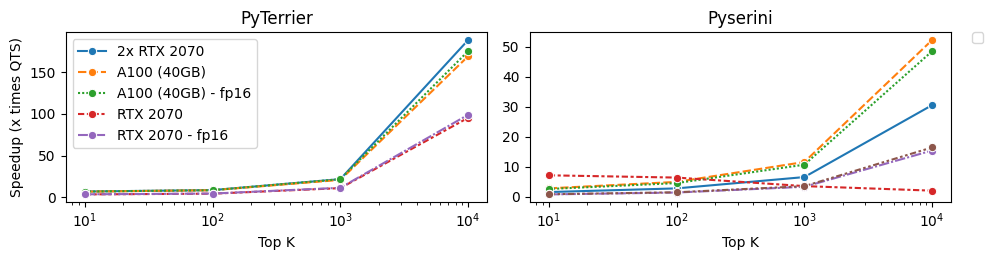

In [120]:
fig, axes = plt.subplots(1, 2, figsize=(10, 2.7))

pyterrier_speedup = pyterrier_speedup.sort_values(by="System")
pyserini_speedup = pyserini_speedup.sort_values(by="System")

for i, data in enumerate([pyserini_speedup, pyterrier_speedup]):
    _legend=False
    if i==1:
        _legend = True
    sns.lineplot(data=data, x='Top K', y='QTS speedup', hue='System', style='System', marker='o', ax=axes[i], legend=(i==0))

    # Settings for better visualization
    #axes[i].set_yscale('log')
    axes[i].set_xscale('log')  # Because your Top K values increase exponentially
    axes[i].set_title('QTS Speedup vs Top K for different Systems')
    #axes[i].set_ylabel('QTS Speedup')
    axes[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    axes[i].set_xlabel('Top K')

    if i == 0:
        axes[i].set_ylabel('Speedup (x times QTS)')
        axes[i].set_title('PyTerrier')
    else:
        axes[i].set_ylabel('')
        axes[i].set_title('Pyserini')
        
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles=handles, labels=labels, loc='best')
#axes[1].legend().set_visible(False)

plt.tight_layout()
plt.show()
    

In [119]:
fig.savefig("speedup.svg", format="svg")

In [104]:
pyserini_rtx2070#, pyserini_a100, pyserini_data_se data_view["QTS"]

,System,Top K,QTS,Score QTS
292,2x RTX 2070,10,163.735715,174.593026
293,2x RTX 2070,100,163.505351,175.238614
294,2x RTX 2070,1000,155.533540,174.843364
295,2x RTX 2070,10000,103.645156,175.451949
318,RTX 2070 - fp16,10,92.992551,94.278950
319,RTX 2070 - fp16,100,92.832543,94.395700
320,RTX 2070 - fp16,1000,90.001508,94.248295
321,RTX 2070 - fp16,10000,69.862041,94.533144
452,RTX 2070,10,86.544218,88.839528
453,RTX 2070,100,87.532442,89.032150


In [78]:
data_se

,System,Top K,QTS
185,pyserini,10,109.460328
186,pyserini,100,62.265838
187,pyserini,1000,26.544633
188,pyserini,10000,5.738643


In [79]:
_view = data_view[data_view["System"]==system]

NameError: name 'data_view' is not defined

In [81]:
#pyserini_speedup
pyterrier_speedup

,System,Top K,QTS,Score QTS,QTS speedup
0,RTX 2070 - fp16,10,115.325406,117.230414,3.657912
1,RTX 2070 - fp16,100,114.873072,117.205868,4.550679
2,RTX 2070 - fp16,1000,110.796912,117.266206,11.453904
3,RTX 2070 - fp16,10000,82.191349,117.727624,98.970859
4,2x RTX 2070,10,207.491240,223.957923,6.988105
5,2x RTX 2070,100,204.346332,223.708273,8.685782
6,2x RTX 2070,1000,192.427879,223.233311,21.804176
7,2x RTX 2070,10000,118.731306,224.196917,188.477102
8,RTX 2070,10,110.871444,113.602369,3.544707
9,RTX 2070,100,111.209300,113.501355,4.406846


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# pivot_data = data.pivot_table(values='QTS', index='System', columns='Top K')
datasets = data['Dataset'].unique()

systems_to_keep = ['pyseniri', #pyserini
                   'pyterrier', 
                   "sparse_retriever_from_pyserini_devices_cpu", 
                   "sparse_retriever_from_pyterrier_devices_cpu",
                   "sparse_retriever_from_pyserini_devices_cuda:0", 
                   "sparse_retriever_from_pyterrier_devices_cuda:0",]
data = data[data['System'].isin(systems_to_keep)]


# Plot for each dataset
for dataset in datasets:
    plt.figure(figsize=(14, 7))
    
    # Filter the data for the specific dataset
    subset_data = data[data['Dataset'] == dataset]
    
    sns.lineplot(x='Top K', y='QTS', hue='System', data=subset_data, marker='o', dashes=False, markersize=6)
    sns.scatterplot(x='Top K', y='QTS', hue='System', data=subset_data, legend=False)
    plt.xscale('log')
    plt.title(f'QTS by top_k for Dataset: {dataset}')
    plt.legend(title='System')
    plt.tight_layout()
    plt.show()


In [8]:
grouped = data.groupby(['System', 'Top K', 'Dataset'])#['QTS'].mean().reset_index()
grouped

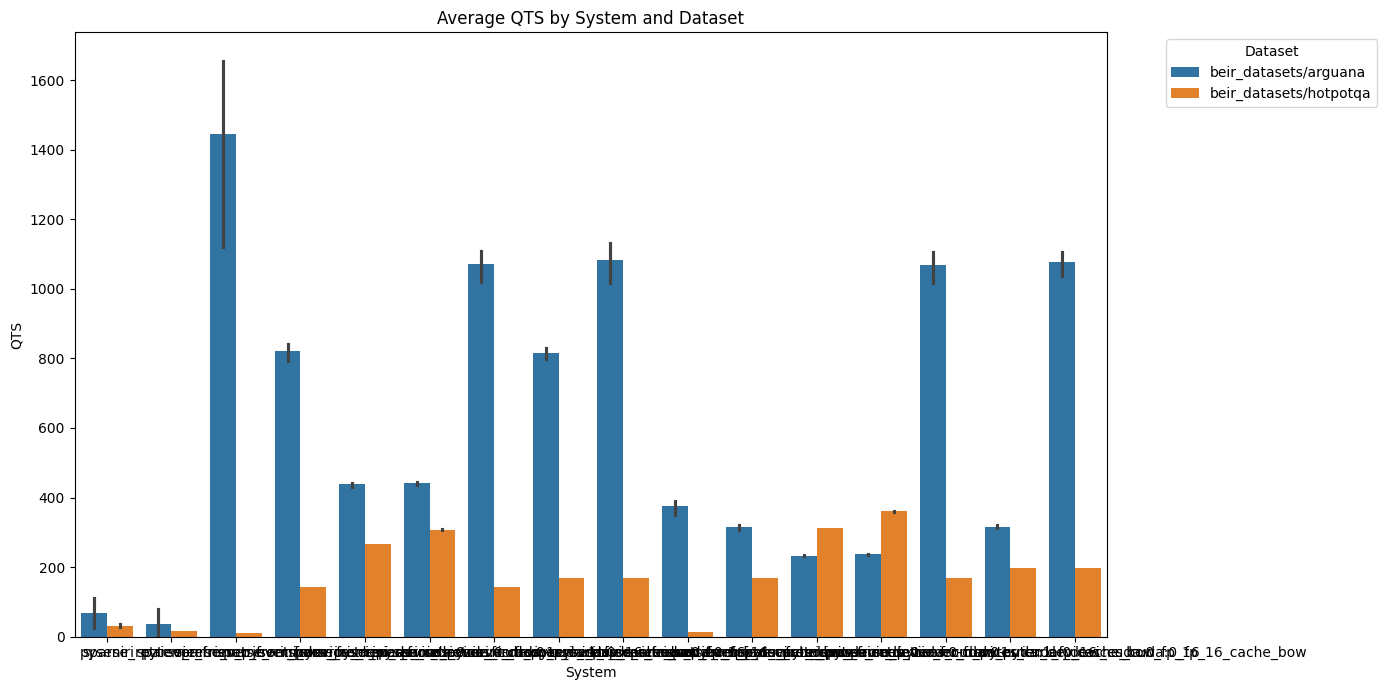

In [52]:
plt.figure(figsize=(14, 7))
sns.barplot(x='System', y='QTS', hue='Dataset', data=grouped)
plt.title('Average QTS by System and Dataset')
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()